<H1> SIMPLE-DA </H1> 
Open and Plot data from computer audio interface, what you do with it depends on the sensor. 
<hr>
<H2>Modification history </H2><br> 
<table>
    <tr>
        <th> Modified </th>
        <th> By </th>
        <th> Reason </th>
    </tr>
    <tr> 
        <td> 13-Mar-25 </td>
        <td> CBL </td> 
        <td> Original </td>
    </tr>
</table>
<hr> 
<H2> References </H2> 
<H2> Notes </H2>
<br> 

In [97]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as const
import scipy  as sp
import glob
import time
import struct

In [98]:
def ReadLine():
    din = wd.read(SampleRate*2) # one second of data, this reads bytes, the input is 2 bytes in length.  
    # Convert the data, input is signed short
    # bytes to short
    sdata = struct.unpack(str(SampleRate)+'h', din)
    y = np.copy(sdata) # make sure it is in numpy format
    # Add in conversion
    
    return y

In [3]:
def ReadBlock():
    """
    Read a full hour of data.
    """
    print("Read a block:", wd.filename)
    wd.seek(0, os.SEEK_SET)   # Rewind the file. Just in case. 


    NFrames = len(y)/SampleRate
    # scale the data
    Conversion = 0.1   # volts/g
    y = y / Gain / Conversion
    # Now do we want to convert it to m/s^2?
    y = const.g * y
    return y

In [134]:
def PlotWelch(yin, PlotType = 0, norm=1.0, SR=16000, NSEG=1):
    # Try this welch method.
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
    N = len(yin)
    SegmentLength = SR/NSEG
    SampleRate = SR
    NFrames = N/SampleRate
    print("Welch:", N, ' NFrames = ', NFrames)
    # returns a vector of frequencies used by fft, inputs are sample rate and 1/sample rate. 
    freq  = np.fft.fftfreq(SampleRate, 1.0/SampleRate)
    # power spectrum, via scipy welch. 'boxcar' means no window, nperseg=len(y) so that fft computed on the whole signal.
    freq2,power2=sp.signal.welch(yin, 
                                 fs = SampleRate,        # Sampling rate
                                 window  = 'hamming',
                                 nperseg = SegmentLength,  # length of each segment
                                 scaling = 'spectrum', 
                                 axis=-1, 
                                 average='mean')
    # Normalization 
    p = power2/norm
    # OVERRIDE for plotting if desired. 
    #N = 400
    # plot supresses DC component.
    # Select type of plot

    if (PlotType == 0):
        plt.semilogy(freq2[1:N],p[1:N])
        #plt.xlim(0,np.max(freq[0:NP]))
        plt.grid()
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude (m/s^2)") 
        plt.ylim((LowerLimit, UpperLimit))
        plt.title(TITLE)
    elif (PlotType == 2):
        yy = 10.0*np.log10(p[1:N])
        plt.plot(freq2[1:N],yy)
        # limit x to 200Hz
        plt.xlim(0.0, 400.0)
        plt.grid()
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("dB") 
        #plt.ylim((LowerLimit, UpperLimit))
        plt.title(TITLE)
        #ax = plt.gca()
        #ax.set_xticks(major_ticksx, minor=True)
        #ax.set_xticks(minor_ticksx, minor=True)
        #ax.set_yticks(major_ticksy, minor=True)
        #ax.set_yticks(minor_ticksy, minor=True)

        # And a corresponding grid
        #ax.grid(which='both')

In [100]:
def ParseName(Fullpath):
    """
    return just the filename from the GLOB. 
    """
    last = Fullpath.rfind('/')
    return Fullpath[last+1:]

Welch: 16000  NFrames =  1.0


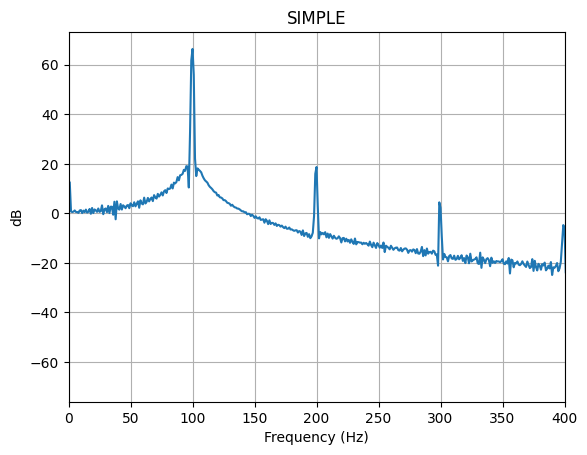

In [136]:
# Testing
Gain = 1
FilePath = '/Users/clirakis/code/Audio/'
File = '2025Accelerometer072_00.acc'
Filename = FilePath + File
SampleRate = 16000
TITLE = 'SIMPLE'
LowerLimit = 1.0e-7
UpperLimit = 1.0e7

wd = open(Filename, 'rb')
# Skip the header information for the moment.
wd.seek(256)
y = ReadLine()
#plt.plot(y)
PlotWelch(y, 2 , 1, SampleRate, 1)
wd.close()

Text(0.5, 1.0, 'Accelerometer')

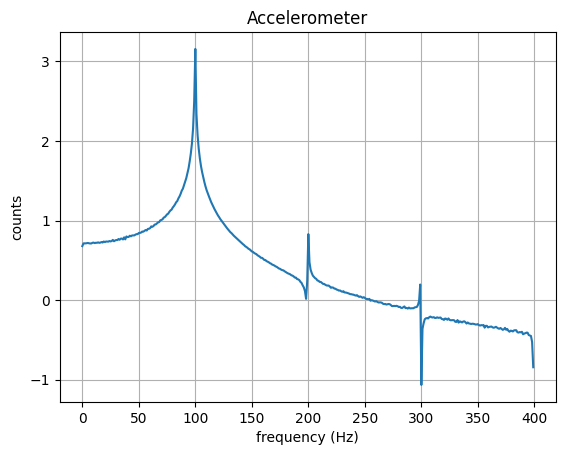

In [111]:
# fooling around with scipy fft. 
# returns a vector of frequencies used by fft, inputs are sample rate and 1/sample rate. 
# Info
# https://docs.scipy.org/doc/scipy/tutorial/signal.html#tutorial-spectralanalysis
#
freq  = np.fft.fftfreq(SampleRate, 1.0/SampleRate)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy.fft.fft
z= sp.fft.fft(y,norm='forward')
z = np.absolute(z)
z = np.log10(z)
zoom = 400
plt.plot(freq[:zoom], z[:zoom])
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('counts')
plt.title('Accelerometer')

In [102]:
def MyHamming(N):
    theta = 2.0 * const.pi * np.arange(0.0, N)/(N-1);
    y = 0.54 - 0.46 * np.cos(theta)
    return y

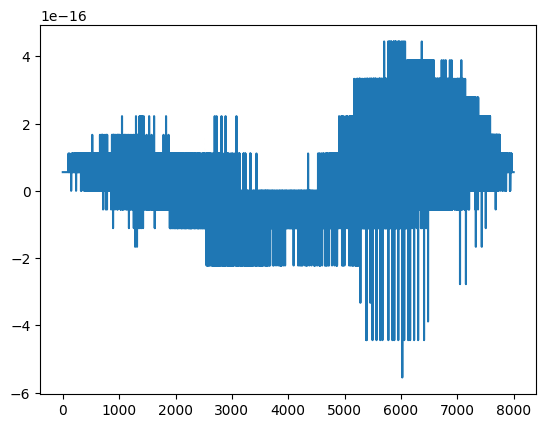

In [92]:
# testing
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hamming.html
y1 = sp.signal.windows.hamming(8000)
y2 = MyHamming(8000)
plt.plot(y1-y2)

In [139]:
# Read in fftw data. 
FilePath = '/Users/clirakis/code/Audio/'
File = '100HzTone.dat'
#File = 'results.dat'
Filename = FilePath + File
SampleRate = 16000
TITLE = 'SIMPLE'
LowerLimit = 1.0e-7
UpperLimit = 1.0e7
wd = open(Filename, 'rb')
# these are doubles and 2 per sample since the data is complex this is 16 bytes per sample
din = wd.read(SampleRate*16) # one second of data, should be complex type
#din = wd.read(128000)
wd.close()
print(len(din))
# reading in complex values
sdata = struct.unpack(str(2*SampleRate)+'d', din)
# this is lazy there is a better way to do it. 
N = SampleRate
y = np.zeros(N,dtype=complex)
for i in range(N):
    y.real[i] = sdata[2*i] 
    y.imag[i] = sdata[2*i+1]
window = MyHamming(N)
yp = y * window

256000


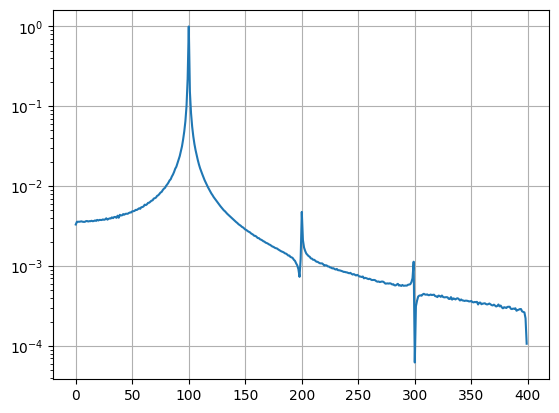

In [140]:
freq  = np.fft.fftfreq(SampleRate, 1.0/SampleRate)
x = np.arange(0,N,0.5)
yy = np.absolute(yp)/N 
ymax = np.max(yy)
yy = yy/ymax    # gets us into dB. 
zoom = 400
#plt.plot(yy[:zoom])
#plt.semilogy(x[:zoom], yy[:zoom])
plt.semilogy(freq[:zoom], yy[:zoom])
#plt.semilogy(freq, yy)
plt.grid()

In [28]:
#
# Cycle through German data. 
#
# PLOT control
TITLE = 'SIMPLE'
LowerLimit = 1.0e-8
UpperLimit = 1.0e-3
# Major ticks every 20, minor ticks every 5
major_ticksx = np.arange(0, 1024, 200)
minor_ticksx = np.arange(0, 1024, 25)
major_ticksy = np.arange(-80.0, -40.0, 10)
minor_ticksy = np.arange(-80.0, -40.0, 5)
# Data CONTROL
Gain = 1
FilePath = '/Users/clirakis/code/Audio'
SearchPath = FilePath + '*.h5'
ListOfFiles = glob.glob(SearchPath)
print('N Files to process: ', len(ListOfFiles))
count  = 0
SampleRate = 16000
for Filename in ListOfFiles:
    print(Filename)
    TITLE = ParseName(Filename)
    #
    # open data file for analysis
    wd = open(Filename, 'rb')
    print("DA Rate: ", SampleRate)
    yout = ReadBlock()
    PlotWelch(yout, 1.0, SampleRate)
    plt.show()
    wd.Close()
    #time.sleep(2)
    val = input('Next or q to end:')
    if (val == 'q'):
        break
    count = count + 1

N Files to process:  0
